### Replot all MCMC fits + Add error statistics
* ***Purpose***: Add plot customization without rerunning to find best fit parameters.
* ***Features***: Includes:
    - Reduced chi-squared of each fit
    - BIC (Bayesian Information Criterion) score for 408-488 hours segment

#### Notebook Structure: 
* Blocks of raw output of sinewaves fit parameters from selected files
* Initization
* MCMC 3 sines:
    - 30-50 hours 
    - 183.5-203.5 hours
    - 409-433 hours
* 408-488 hours data:
    - MCMC 4 sines - with BIC calculated
    - hyperOPT 3 sines - with BIC calculated

### Initialization 

In [83]:
from AROMA import *
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import RegscorePy

%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

pi = np.pi 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

data_path = '~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/luhman_16ab_sector36-37_longPeriodsRemoved.txt'
data = pd.read_csv(data_path, header=0, delimiter='\t')
plotPath = join(homedir, 'plots/replotFitSegment')
data = data # full light curve

def: find_nearest(array, value)


In [78]:
def model3(theta, t):
    a1, f1, a2, f2, a3, f3, w1, w2, w3 = theta
    model = 1 + a1*np.sin(w1*t + f1) + a2*np.sin(w2*t + f2) + a3*np.sin(w3*t + f3)
    return model

def model4(theta, t):
    a0, a1, f1, a2, f2, a3, f3, a4, f4, w1, w2, w3, w4, dt = theta
    model = a0 + a1*np.sin(w1*(t+dt) + f1) + a2*np.sin(w2*(t+dt) + f2) + a3*np.sin(w3*(t+dt) + f3) + a4*np.sin(w4*(t+dt) + f4) 
    return model

def model3alt(theta, t):
    a0, a1, f1, a2, f2, a3, f3, w1, w2, w3, dt = theta
    model = a0 + a1*np.sin(w1*(t+dt) + f1) + a2*np.sin(w2*(t+dt) + f2) + a3*np.sin(w3*(t+dt) + f3)
    return model

### 3-Sines: [30-50] hours

Best theta fit
a1, f1:  [ 0.00816288 -2.48016352]
a2, f2:  [ 0.01824682 -0.68744463]
a3, f3:  [0.01038991 1.48751008]
w1, w2, w3:  [1.15595944 1.29832476 2.52735663]
periods 1, 2, 3 (hours):  [5.43547212 4.83945581 2.48606992]
Reduced chi^2: 2.72e-01


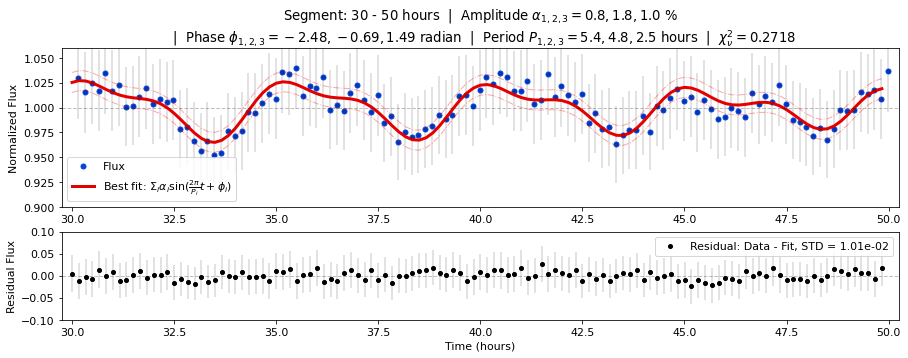

In [114]:
### Code copy from Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/[MCMC_30-50hours]lightCurveSyntheticFit.ipynb
tlow, thigh = [30,50]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.lc_corrected)
lc_err = 0.05*np.array(subset.lc_corrected)
df = ((time, lc, lc_err))

theta_max = np.array([0.00816288, -2.48016352, 0.01824682, -0.68744463, 0.01038991, 1.48751008, 1.15595944, 1.29832476, 2.52735663])

print('Best theta fit')
print('a1, f1: ', theta_max[0:2])
print('a2, f2: ', theta_max[2:4])
print('a3, f3: ', theta_max[4:6])
print('w1, w2, w3: ', theta_max[6:9])
print('periods 1, 2, 3 (hours): ', 2*pi/theta_max[6:9])

best_fit_model = model3(theta_max, time)

# reduced chi-squared
dataVar = np.var(lc)
chi = np.sum((lc-best_fit_model)**2/dataVar)
degreeOfFreedom = len(time) - len(theta_max)
reducedChiSq = chi/degreeOfFreedom
print('Reduced chi^2: %.2e'%reducedChiSq)

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,5), gridspec_kw={'height_ratios': [1.8, 1]})
a0.set_title('Segment: %i - %i hours'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $ %%' %(theta_max[0]*100, theta_max[2]*100, theta_max[4]*100)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $ radian' %(theta_max[1], theta_max[3], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8]) 
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq) )
timep = time+0.15
a0.plot(timep,lc,label='Flux',ls='', marker='o', ms=5, c='xkcd:blue')
a0.plot(time, best_fit_model,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=3, c='xkcd:red')
a0.legend()
a0.set_xlim(tlow-0.25,thigh+0.25), a0.set_ylim((0.900, 1.060)), 
a0.set_ylabel('Normalized Flux')

# plot residual
fitResidual = lc - best_fit_model
resStd = np.std(fitResidual)
a1.plot(time,fitResidual,label='Residual: Data - Fit, STD = %.2e'%resStd, ls='', marker='o', ms=4, c='k'), 
a1.legend()
a1.set_ylim((-0.1,0.1))
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Time (hours)')
a1.set_xlim(tlow-0.25,thigh+0.25)

# plot error lines
a0.axhline(y=1.0, xmin=0, xmax=100, ls='--', c='k', lw=1, alpha=0.25)
a0.errorbar(timep, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
a1.axhline(y=0.0, xmin=0, xmax=100, ls='--', c='k', lw=1, alpha=0.25)
a1.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
# plot residual
a0.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
a0.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)

## Saving
save = False
# save = True
if save:
    handle_code = 'MCMC'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show()

### 3-Sines: [183.5-203.5] hours

Reduced chi^2: 2.68e-01


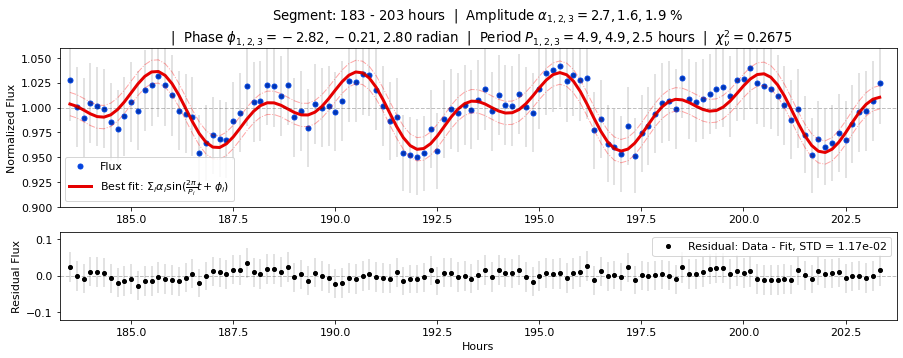

In [115]:
### Code copy from Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/[MCMC_180-210hours]lightCurveSyntheticFit.ipynb
tlow, thigh = [183.5,203.5]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.lc_corrected)
lc_err = 0.05*np.array(subset.lc_corrected)
df = ((time, lc, lc_err))

theta_max = np.array([0.02728809, -2.81504722, 0.01627766, -0.20773621, 0.01893841, 2.80299095, 1.28286378, 1.29032051, 2.53059854])

best_fit_model = model3(theta_max,time)

# reduced chi-squared
dataVar = np.var(lc)
chi = np.sum((lc-best_fit_model)**2/dataVar)
degreeOfFreedom = len(time) - len(theta_max)
reducedChiSq = chi/degreeOfFreedom
print('Reduced chi^2: %.2e'%reducedChiSq)

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,5), gridspec_kw={'height_ratios': [1.8, 1]})
a0.set_title('Segment: %i - %i hours'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $ %%' %(theta_max[0]*100, theta_max[2]*100, theta_max[4]*100)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $ radian' %(theta_max[1], theta_max[3], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8])
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq) )
# a0.axhline(y=1.0, xmin=tlow, xmax=thigh, ls='--', lw=1)
fitp = 1.108*best_fit_model-0.11

# plot data and fit
a0.plot(time,lc,label='Flux',ls='', marker='o', ms=5, c='xkcd:blue')
a0.plot(time,fitp,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=3, c='xkcd:red')
a0.set_ylim((0.900, 1.060)), a0.legend()
a0.set_xlim(tlow-0.25,thigh+0.25)
a0.set_ylabel('Normalized Flux')

# plot fit residual
fitResidual = lc - (fitp)
resStd = np.std(fitResidual)
a1.plot(time,fitResidual,label='Residual: Data - Fit, STD = %.2e'%resStd, ls='', marker='o', ms=4, c='k'),  
a1.legend()
a1.set_ylim((-0.12,0.12))
a1.set_xlim(tlow-0.25,thigh+0.25)
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Hours')

# plot error lines
a0.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
a0.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
a1.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
a1.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
# plot residual
a0.plot(time, fitp+resStd, ls='-.', c='r', lw=1, alpha=0.35)
a0.plot(time, fitp-resStd, ls='-.', c='r', lw=1, alpha=0.35)

## Saving
# save = True
save = False
if save:
    handle_code = 'MCMC'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show()

### 3-Sines: [409-433] hours

Reduced chi^2: 4.2402e-01


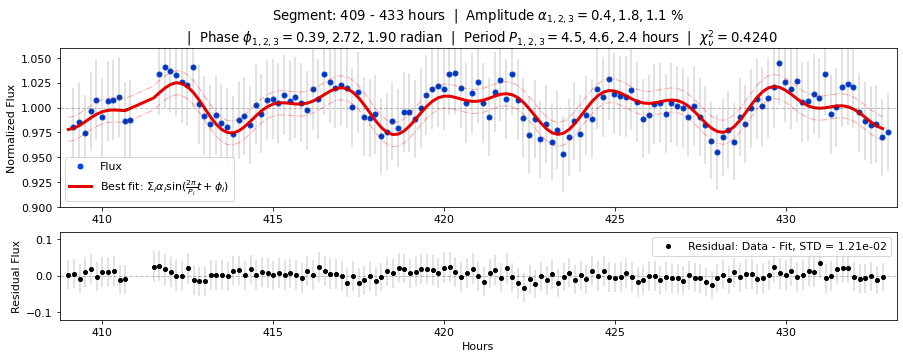

In [116]:
### Code copy from Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/[MCMC_409-433hours]lightCurveSyntheticFit.ipynb
tlow, thigh = [409,433]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.lc_corrected)
lc_err = 0.05*np.array(subset.lc_corrected)
df = ((time, lc, lc_err))

theta_max = np.array([0.00373143, 0.38581555, 0.01780357, 2.71881086, 0.01060318, 1.89761165, 1.40985263, 1.36985833, 2.57409846])

best_fit_model = model3(theta_max,time)

# reduced chi-squared
dataVar = np.var(lc)
chi = np.sum((lc-best_fit_model)**2/dataVar)
degreeOfFreedom = len(time) - len(theta_max)
reducedChiSq = chi/degreeOfFreedom
print('Reduced chi^2: %.4e'%reducedChiSq)

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,5), gridspec_kw={'height_ratios': [1.8, 1]})
a0.set_title('Segment: %i - %i hours'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $ %%' %(theta_max[0]*100, theta_max[2]*100, theta_max[4]*100)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $ radian' %(theta_max[1], theta_max[3], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8])
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq) )

timep = time+0.15
# Plot data and fit
a0.plot(timep,lc,label='Flux',ls='', marker='o', ms=5, c='xkcd:blue')
# a0.plot(time,lc,label='Flux',ls='', marker='o', ms=4, c='xkcd:blue')
a0.plot(time,best_fit_model,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=3, c='xkcd:red')
a0.set_ylim((0.900, 1.060)), a0.legend()
a0.set_xlim(tlow-0.25,thigh+0.25)
a0.set_ylabel('Normalized Flux')

# Plot residual
fitResidual = lc - best_fit_model
resStd = np.std(fitResidual)
a1.plot(time,fitResidual,label='Residual: Data - Fit, STD = %.2e'%resStd, ls='', marker='o', ms=4, c='k'), 
a1.legend()
a1.set_ylim((-0.12,0.12))
a1.set_xlim(tlow-0.25,thigh+0.25)
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Hours')

# plot error lines
a0.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
a0.errorbar(timep, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
a1.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
a1.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
# plot residual
a0.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
a0.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)

## Saving
save = True
# save = False
if save:
    handle_code = 'MCMC'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show()

### 4-Sines: [408-488] hours

Reduced chi^2: 7.4115e-01
BIC score:  -1954.2593541205254


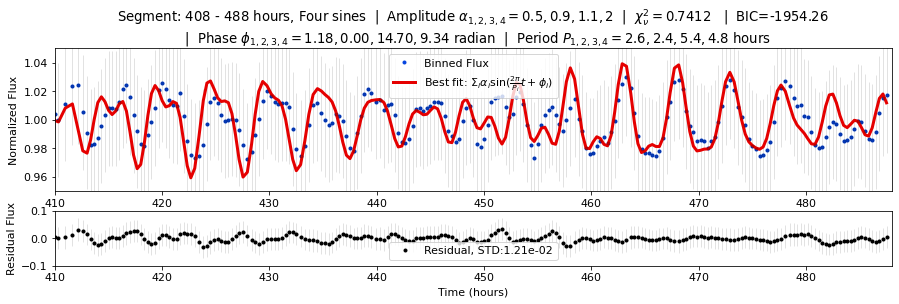

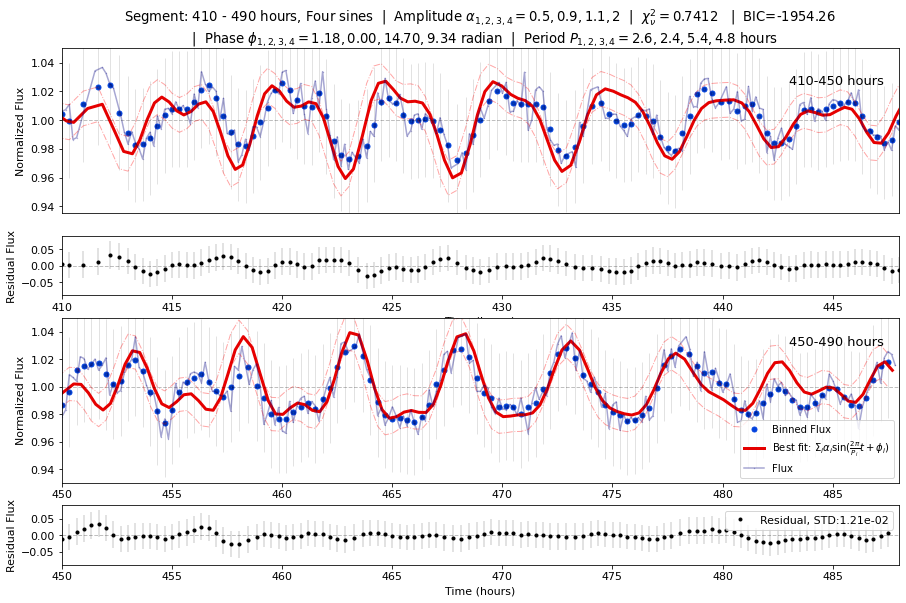

In [132]:
### Code copy from Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/4sine[MCMC_408-488hours]lightCurveSyntheticFit.ipynb
tlow, thigh = [408,488]

# Data preprocessing
fluxlow, fluxhigh = 0.96, 1.04
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
subset = subset.query('lc_corrected >= %f & lc_corrected <= %f'%(fluxlow, fluxhigh))
filter_rolling = True

timearr00 = subset.TIME
lcarr00 = subset.lc_corrected

if filter_rolling:
    # time = subset.rolling(window=5).mean().dropna()['TIME']
    # lc = subset.rolling(window=5).mean().dropna()['lc_corrected']
    
    time = subset.rolling(window=5).mean().dropna()['TIME'][::2]
    lc = subset.rolling(window=5).mean().dropna()['lc_corrected'][::2]
else:
    time = subset['TIME']
    lc = subset['lc_corrected']
    
lc_err = 0.05*np.array(subset.lc_corrected)
df = ((time, lc, lc_err))

theta_max = np.array([0.999757952821482, 4.95549283e-03, -5.02818631e+00, 0.00931066, -4.59375692, 0.01097229, -3.59378784, 0.01865923, -7.4125442,
                        2.41094185, 2.57801593, 1.16280883, 1.32214682, -9.678628814935678])

best_fit_model = model4(theta_max, time)

# reduced chi-squared
dataVar = np.var(lc)
chi = np.sum((lc-best_fit_model)**2/dataVar)
degreeOfFreedom = len(time) - len(theta_max)
reducedChiSq = chi/degreeOfFreedom
print('Reduced chi^2: %.4e'%reducedChiSq)

# bayesian information criterion score
BIC_4S_score = RegscorePy.bic.bic(y=lc, y_pred=best_fit_model, p=len(theta_max))
print('BIC score: ', BIC_4S_score)

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,4), gridspec_kw={'height_ratios': [2.6, 1]})

### FIVE SINES
# a0.set_title('Segment: %i - %i hours'%(tlow, thigh)
#            + r'  |  Amplitude $ \alpha_{1,2,3,4,5}=%.1f, %.1f, %.1f, %.1f, %.1f $' %(theta_max[0]*100, theta_max[2]*100, theta_max[4]*100, theta_max[6]*100, theta_max[8]*100)
#            + '\n' + r'  |  Phase $ \phi_{1,2,3,4,5}=%.2f, %.2f, %.2f, %.2f, %.2f $' %(theta_max[1], theta_max[3], theta_max[5], theta_max[7], theta_max[9])
#            + r'  |  Period $ P_{1,2,3,4,5}=%.1f, %.1f, %.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[10], 2*pi/theta_max[11], 2*pi/theta_max[12], 2*pi/theta_max[13], 2*pi/theta_max[14]) )

### FOUR SINES
phase_shift = np.array([theta_max[2] + theta_max[9]*theta_max[13],
               theta_max[4] + theta_max[10]*theta_max[13],
               theta_max[6] + theta_max[11]*theta_max[13],
               theta_max[8] + theta_max[12]*theta_max[13]])
phase_shift = phase_shift + abs(phase_shift.min())

a0.set_title('Segment: %i - %i hours, Four sines'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3,4}=%.1f, %.1f, %.1f , %1.f$' %(theta_max[1]*100, theta_max[3]*100, theta_max[5]*100, theta_max[7]*100)
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq)
           + r'  |  BIC=%.2f' %(BIC_4S_score)
           + '\n' + r'  |  Phase $ \phi_{1,2,3,4}=%.2f, %.2f, %.2f , %.2f$ radian' %(phase_shift[0], phase_shift[1], phase_shift[2], phase_shift[3])
           + r'  |  Period $ P_{1,2,3,4}=%.1f, %.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[9], 2*pi/theta_max[10], 2*pi/theta_max[11], 2*pi/theta_max[12]) )

# a0.axhline(y=1.0, xmin=tlow, xmax=thigh, ls='--', lw=1)
a0.plot(time,lc,label='Binned Flux',ls='', marker='o', ms=3, c='xkcd:blue')
a0.plot(time,best_fit_model,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=3, c='xkcd:red')
a0.set_ylim((0.950, 1.05)), a0.legend()
a0.set_xlim((410, 488))
a0.set_ylabel('Normalized Flux')
a0.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)

fitResidual = lc - best_fit_model
resStd = np.std(fitResidual)
a1.plot(time,fitResidual,label='Residual, STD:%.2e'%resStd, ls='', marker='o', ms=3, c='k'), 
a1.legend()
a1.set_ylim((-0.1,0.1))
a1.set_xlim((410, 488))
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Time (hours)')
a1.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
# a1.set_xlim((tlow, thigh-20))
# a0.set_xlim((tlow, thigh-20))

mini_segment = True
shift = +0.2
f2, (a2, a2b, a3, a3b) = plt.subplots(4, 1, figsize = (15,9.5), gridspec_kw={'height_ratios': [1, 0.36, 1, 0.36]})
if mini_segment:
    
    a2.set_title('Segment: %i - %i hours, Four sines'%(410, 490)
           + r'  |  Amplitude $ \alpha_{1,2,3,4}=%.1f, %.1f, %.1f , %1.f$' %(theta_max[1]*100, theta_max[3]*100, theta_max[5]*100, theta_max[7]*100)
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq)
           + r'  |  BIC=%.2f' %(BIC_4S_score)
           + '\n' + r'  |  Phase $ \phi_{1,2,3,4}=%.2f, %.2f, %.2f , %.2f$ radian' %(phase_shift[0], phase_shift[1], phase_shift[2], phase_shift[3])
           + r'  |  Period $ P_{1,2,3,4}=%.1f, %.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[9], 2*pi/theta_max[10], 2*pi/theta_max[11], 2*pi/theta_max[12]) 
            )      
    
    ## 40 hours plot A
    timep = time+shift
    a2.plot(time, lc, label= 'Binned Flux', c= 'xkcd:blue', ms=5, ls='', marker='o', lw=0.65)
    # a2.errorbar(time, lc, yerr=0.04*lc, fmt='o', ms=3)
    a2.plot(timep, best_fit_model, label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', c='xkcd:red', lw=3)
    a2.plot(timearr00, lcarr00, ls='-', label='Flux', marker='.', ms=0.75, alpha=0.35, c='navy')
    a2.set_ylabel('Normalized Flux'), a2.set_ylim((0.935, 1.05)), a2.set_xlim((410, 448))
    a2.set_xticks([])
    a2.text(443, 1.025, '410-450 hours', fontsize=13)
    # plt.legend()
    
    # Plot residual
    a2b.plot(time,fitResidual, ls='', marker='o', ms=3, c='k'), 
    a2b.set_ylim((-0.09,0.09))
    a2b.set_xlim((410, 448))
    a2b.set_ylabel('Residual Flux')
    a2b.set_xlabel('Time (hours)')
    
    ## plot error lines
    a2.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a2.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
    a2b.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a2b.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
    # plot residual
    a2.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
    a2.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)
    
    ## 40 hours plot B
    a3.plot(time, lc, label= 'Binned Flux', c= 'xkcd:blue', ms=5, ls='', marker='o', lw=0.65)
    a3.plot(time+shift, best_fit_model, label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', c='xkcd:red', lw=3)
    a3.plot(timearr00, lcarr00, ls='-', label='Flux', marker='.', ms=0.75, alpha=0.35, c='navy')
    a3.set_ylabel('Normalized Flux'), a3.set_ylim((0.93, 1.05)), a3.set_xlim((450, 488))
    a3.set_xlabel('Time (hours)'), a3.legend(loc='lower right', fontsize=10)
    a3.text(483, 1.03, '450-490 hours', fontsize=13)
    # a3.text(0.97, 443, 'Zoomed out',transform=a3.transAxes)
    
    ## plot error lines
    a3.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a3.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
    a3b.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a3b.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
    # plot residual
    a3.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
    a3.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)
    
    # Plot residual
    a3b.plot(time,fitResidual,label='Residual, STD:%.2e'%resStd, ls='', marker='o', ms=3, c='k'), 
    a3b.legend()
    a3b.set_ylim((-0.09,0.09))
    a3b.set_xlim((450, 488))
    a3b.set_ylabel('Residual Flux')
    a3b.set_xlabel('Time (hours)')

## Saving
save = True
# save = False
if save:
    handle_code = 'MCMC_4sines'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut + 'panelA' + '.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut + 'panelA' + '.png', dpi=300, format='png', bbox_inches = 'tight')
    
    f2.savefig(plotOut + 'panelB' + '.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f2.savefig(plotOut + 'panelB' + '.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show();

### Run to test: 3-Sines: [408-488] hours

**Example**

Suppose you have a set of data with 50 observation points, and Model 1 estimates 3 parameters. Model 2 estimates 4 parameters. Let’s say the log of your maximum likelihood for model 1 is a; and for model 2 it is 2a. Using the formula k log(n)- 2log(L(θ)):

Calculating SIC on this data gives us:

Model 1: 3log(50) – 2a = 5.1 – 2a

Model 2: 4log(50) – 4a = 6.8 – 4a

So ΔBIC is 1.7 – 2a.

Since the evidence that the Bayesian Information Criterion gives us for model 1 will only be ‘worth mentioning’ if 1.7 – 2a > 2, we can only claim conclusive results if -2a > 0.3; that is to say, a < -0.15.

**References**

Claeskins, G. & Hkort, N. (2008). Model Selection and Model Averaging (Cambridge Series in Statistical and Probabilistic Mathematics) 1st Edition. Cambridge University Press.
Fabozzi, Focardi, Rachev & Arshanapalli. The Basics of Financial Econometrics: Tools, Concepts, and Asset Management Applications. Appendix E: Model Selection Criterion: AIC and BIC.

Reduced chi^2: 1.0056e+00
BIC score:  -1897.225955260727
4-sine model has lower BIC; BIC difference= 57.03339885979835


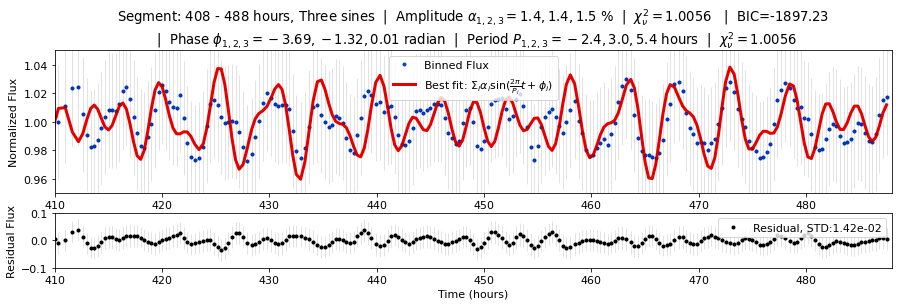

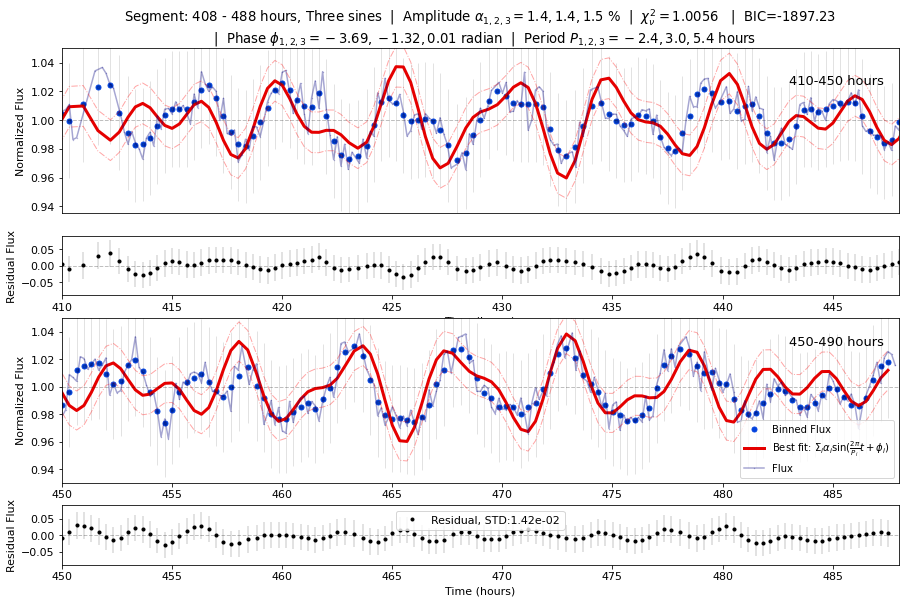

In [131]:
### Code copy from Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/4sine[MCMC_408-488hours]lightCurveSyntheticFit.ipynb
tlow, thigh = [408,488]

# Data preprocessing
fluxlow, fluxhigh = 0.96, 1.04
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
subset = subset.query('lc_corrected >= %f & lc_corrected <= %f'%(fluxlow, fluxhigh))
filter_rolling = True

timearr00 = subset.TIME
lcarr00 = subset.lc_corrected

if filter_rolling:
    # time = subset.rolling(window=5).mean().dropna()['TIME']
    # lc = subset.rolling(window=5).mean().dropna()['lc_corrected']
    
    time = subset.rolling(window=5).mean().dropna()['TIME'][::2]
    lc = subset.rolling(window=5).mean().dropna()['lc_corrected'][::2]
else:
    time = subset['TIME']
    lc = subset['lc_corrected']
    
lc_err = 0.05*np.array(subset.lc_corrected)
df = ((time, lc, lc_err))

theta_max = np.array([1.0000449971728513, 0.013626493427858577, -3.6857183471505888, 0.013583777629485308, -1.3199188624499176,
0.014534406741654241, -2.5884363544381888, 2.1180873340296844, 1.159940890141111, 1.3276205653665687, -10.609647886626366])

best_fit_model = model3alt(theta_max, time)

# reduced chi-squared
dataVar = np.var(lc)
chi = np.sum((lc-best_fit_model)**2/dataVar)
degreeOfFreedom = len(time) - len(theta_max)
reducedChiSq = chi/degreeOfFreedom
print('Reduced chi^2: %.4e'%reducedChiSq)

# bayesian information criterion (BIC)
BIC_3S_score = RegscorePy.bic.bic(y=lc, y_pred=best_fit_model, p=len(theta_max))
print('BIC score: ', BIC_3S_score)
print('4-sine model has lower BIC; BIC difference=', abs(BIC_4S_score - BIC_3S_score))

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,4), gridspec_kw={'height_ratios': [2.6, 1]})

### THREE SINES
a0.set_title('Segment: %i - %i hours, Three sines'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $ %%' %(theta_max[1]*100, theta_max[3]*100, theta_max[5]*100)
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq)
           + r'  |  BIC=%.2f' %(BIC_3S_score)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $ radian' %(theta_max[2], theta_max[4], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8])
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq) )

# a0.axhline(y=1.0, xmin=tlow, xmax=thigh, ls='--', lw=1)
a0.plot(time,lc,label='Binned Flux',ls='', marker='o', ms=3, c='xkcd:blue')
a0.plot(time,best_fit_model,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=3, c='xkcd:red')
a0.set_ylim((0.950, 1.05)), a0.legend()
a0.set_xlim((410, 488))
a0.set_ylabel('Normalized Flux')
a0.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)

fitResidual = lc - best_fit_model
resStd = np.std(fitResidual)
a1.plot(time,fitResidual,label='Residual, STD:%.2e'%resStd, ls='', marker='o', ms=3, c='k'), 
a1.legend()
a1.set_ylim((-0.1,0.1))
a1.set_xlim((410, 488))
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Time (hours)')
a1.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
# a1.set_xlim((tlow, thigh-20))
# a0.set_xlim((tlow, thigh-20))

mini_segment = True
shift = +0.0
f2, (a2, a2b, a3, a3b) = plt.subplots(4, 1, figsize = (15,9.5), gridspec_kw={'height_ratios': [1, 0.36, 1, 0.36]})
if mini_segment:
    
    a2.set_title('Segment: %i - %i hours, Three sines'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $ %%' %(theta_max[1]*100, theta_max[3]*100, theta_max[5]*100)
           + r'  |  $\chi_\nu^2=%.4f$ ' %(reducedChiSq)
           + r'  |  BIC=%.2f' %(BIC_3S_score)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $ radian' %(theta_max[2], theta_max[4], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8])
           )
    
    ## 40 hours plot A
    timep = time+shift
    a2.plot(time, lc, label= 'Binned Flux', c= 'xkcd:blue', ms=5, ls='', marker='o', lw=0.65)
    # a2.errorbar(time, lc, yerr=0.04*lc, fmt='o', ms=3)
    a2.plot(timep, best_fit_model, label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', c='xkcd:red', lw=3)
    a2.plot(timearr00, lcarr00, ls='-', label='Flux', marker='.', ms=0.75, alpha=0.35, c='navy')
    a2.set_ylabel('Normalized Flux'), a2.set_ylim((0.935, 1.05)), a2.set_xlim((410, 448))
    a2.set_xticks([])
    a2.text(443, 1.025, '410-450 hours', fontsize=13)
    # plt.legend()
    
    # Plot residual
    a2b.plot(time,fitResidual, ls='', marker='o', ms=3, c='k'), 
    a2b.set_ylim((-0.09,0.09))
    a2b.set_xlim((410, 448))
    a2b.set_ylabel('Residual Flux')
    a2b.set_xlabel('Time (hours)')
    
    ## plot error lines
    a2.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a2.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
    a2b.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a2b.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
    # plot residual
    a2.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
    a2.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)
    
    ## 40 hours plot B
    a3.plot(time, lc, label= 'Binned Flux', c= 'xkcd:blue', ms=5, ls='', marker='o', lw=0.65)
    a3.plot(time+shift, best_fit_model, label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', c='xkcd:red', lw=3)
    a3.plot(timearr00, lcarr00, ls='-', label='Flux', marker='.', ms=0.75, alpha=0.35, c='navy')
    a3.set_ylabel('Normalized Flux'), a3.set_ylim((0.93, 1.05)), a3.set_xlim((450, 488))
    a3.set_xlabel('Time (hours)'), a3.legend(loc='lower right', fontsize=10)
    a3.text(483, 1.03, '450-490 hours', fontsize=13)
    # a3.text(0.97, 443, 'Zoomed out',transform=a3.transAxes)
    
    ## plot error lines
    a3.axhline(y=1.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a3.errorbar(time, lc, yerr=0.04*lc, fmt='.', color='k', linestyle='', lw=0.75, alpha=0.15)
    a3b.axhline(y=0.0, xmin=0, xmax=1000, ls='--', c='k', lw=1, alpha=0.25)
    a3b.errorbar(time, fitResidual, yerr=0.04*lc, fmt='.', color='k', linestyle='', alpha=0.15)
    # plot residual
    a3.plot(time, best_fit_model+resStd, ls='-.', c='r', lw=1, alpha=0.35)
    a3.plot(time, best_fit_model-resStd, ls='-.', c='r', lw=1, alpha=0.35)
    
    # Plot residual
    a3b.plot(time,fitResidual,label='Residual, STD:%.2e'%resStd, ls='', marker='o', ms=3, c='k'), 
    a3b.legend()
    a3b.set_ylim((-0.09,0.09))
    a3b.set_xlim((450, 488))
    a3b.set_ylabel('Residual Flux')
    a3b.set_xlabel('Time (hours)')

## Saving
save = True
# save = False
if save:
    handle_code = 'hyperOPT_3sines'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut + 'panelA' + '.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut + 'panelA' + '.png', dpi=300, format='png', bbox_inches = 'tight')
    
    f2.savefig(plotOut + 'panelB' + '.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f2.savefig(plotOut + 'panelB' + '.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show();

*"A difference in BICs greater than 10 constitutes ‘very strong’ evidence in favor of the model with smaller BIC."*

Bayesian Information Criterion
The BIC is a well-known general approach to model selection that favors more parsimonious models over more complex models (i.e., it adds a penalty based on the number of parameters being estimated in the model) (Schwarz, 1978; Raftery, 1995). One form for calculating the BIC is given by

$$BIC = T_m - df_m \ln(n)$$

where Tm is the chi-square statistic for the hypothesized model. In this form, a BIC greater than 0 favors the saturated model (i.e., the model that allows all observed variables to be intercorrelated with no assumed model structure), while a BIC less than 0 favors the hypothesized model. Furthermore, the BIC can be used to assess two competing models. Following Jeffrey-Raftery's (1995) guidelines, if the difference in BICs between the two models is 0–2, this constitutes ‘weak’ evidence in favor of the model with the smaller BIC; a difference in BICs between 2 and 6 constitutes ‘positive’ evidence; a difference in BICs between 6 and 10 constitutes ‘strong’ evidence; and a difference in BICs greater than 10 constitutes ‘very strong’ evidence in favor of the model with smaller BIC.

https://www.sciencedirect.com/topics/social-sciences/bayesian-information-criterion#:~:text=Following%20Jeffrey%2DRaftery's%20(1995),10%20constitutes%20'strong'%20evidence%3B

**CHECK OUT REGSCOREPY*

https://pypi.org/project/RegscorePy/